# Exploring Euler's Formula and Phasors in Electronics
**Authors: ilia Khosravi Khorashad**
**contact address: ilia.khosravikhorashad@mail.um.ac.ir**

## Introduction
In electrical engineering, phasors and Euler's formula are indispensable tools for simplifying the analysis of circuits involving sinusoidal signals. This article delves into the concepts discussed in the video: the role of imaginary numbers, Euler's formula, and phasors in electronic circuits.

We'll explore how these mathematical tools simplify the analysis of circuits with capacitors and resistors. Then, we'll model and simulate a simple RC circuit using Python libraries like PySpice and Schemdraw. Finally, we visualize the results with Matplotlib.

![eulers formula](./images/eulers-formula-in-relation-to-phasors.png)

Resistors and Sinusoids
Resistors are simple circuit elements that follow Ohm's Law: 
V = IR where voltage (V) is directly proportional to current (I), and R is the resistance.
When a sinusoidal voltage is applied across a resistor, the current through it also varies sinusoidally. Importantly, voltage and current are "in phase", meaning they reach their maximum and minimum values at the same time.
For example, If the voltage is:
$$ V(t) = V_0 \cos(\omega t), $$
then the current is:
$$ I(t) = \frac{V_0}{R} \cos(\omega t). $$
There is no delay (phase shift) between voltage and current in a resistor.
### Capacitors and Phase Shifts

- A **capacitor** stores energy in an electric field and responds differently to sinusoidal inputs. The current through a capacitor is proportional to the rate of change (derivative) of the voltage:
  $$ I(t) = C \frac{dV(t)}{dt} $$

- For sinusoidal voltage:
  $$ V(t) = V_0 \cos(\omega t) $$
  the derivative introduces a phase shift:
  $$ \frac{d}{dt}\left[V_0 \cos(\omega t)\right] = -\omega V_0 \sin(\omega t) $$
  which can also be rewritten as:
  $$ -\omega V_0 \cos\left(\omega t + \frac{\pi}{2}\right) $$

- This shows that the **current leads the voltage by 90°** in a capacitor.

- The phase shift adds complexity to circuit analysis when combining capacitors with resistors, as they don’t operate "in sync" like resistors alone.

---

### Euler's Formula and Phasors

#### Euler's Formula:
$$ e^{j\theta} = \cos\theta + j\sin\theta $$

- This equation bridges exponential and trigonometric representations of sinusoidal functions.

- A sinusoidal signal (e.g.,  \( $$ V(t) = V_0 \cos(\omega t) $$ \)) can be expressed in exponential form:
  $$ V(t) = \text{Re}\left[V_0 e^{j\omega t}\right] $$
  where \( $$\text{Re}$$ \) represents the real part of the complex exponential.

#### Phasors:
- **Phasors** use Euler's formula to represent sinusoidal signals as rotating vectors in the complex plane. For instance:
  $$  V(t) = V_0 e^{j\omega t} \quad \text{(phasor form)}. $$
  - The amplitude is \( V_0 \), and the angle represents the phase of the signal.

#### Why Euler's Formula Helps:
- It simplifies **differential equations** in AC circuits into **algebraic equations**.

- For example, the derivative (current in a capacitor) can be replaced by multiplication in the exponential domain:
  $$ I(t) = C \frac{dV(t)}{dt} \quad \Rightarrow \quad I = j\omega C V $$
  where \($$ j\omega C $$\) is the **impedance** of the capacitor in the frequency domain.
  

---

### Practical Insights in Circuit Analysis

Euler’s formula enables us to:

1. Represent sinusoidal inputs as phasors.
2. Convert time-domain differential equations into simpler frequency-domain algebraic equations.
3. Solve for voltage, current, and impedance algebraically.
4. Convert back to the time domain using the real part of the complex solution.

For example:

- In an RC circuit with a sinusoidal input \( V_{\text{in}}(t) = V_0 \cos(\omega t) \), the output voltage across the capacitor can be determined without solving a differential equation. Instead, we:
  1. Replace \( V_{\text{in}} \) with \( V_0 e^{j\omega t} \) (phasor form).
  2. Use algebra to calculate the phasor output voltage.
  3. Extract the real part of the result to return to the time domain.

This process reduces computational complexity and allows engineers to focus on understanding the behavior of circuits under sinusoidal inputs.


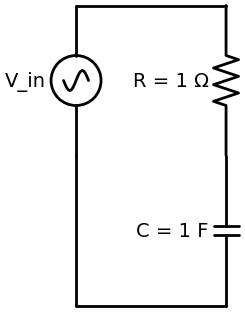

In [36]:
import schemdraw
import schemdraw.elements as elm

with schemdraw.Drawing() as d:
    d += elm.SourceSin().label('V_in').at((0, 0)) 
    d += elm.Line().right().length(3)
    d += elm.Resistor().down().label('R = 1 Ω')  
    d += elm.Capacitor().down().label('C = 1 F') 
    d += elm.Line().left().length(3)
    d += elm.Line().up().to((0, 0)) 
    d.save('rc_circuit_diagram.png')


Node name 'in' is a Python keyword


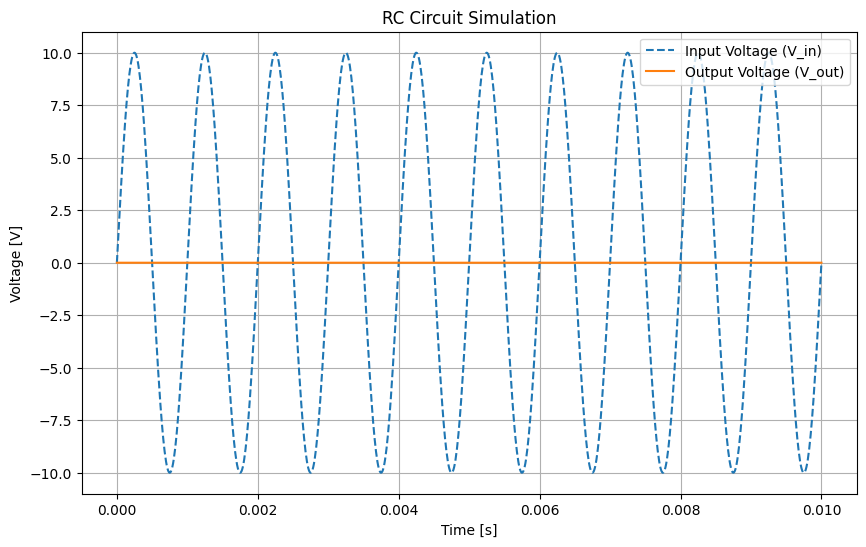

In [37]:
from PySpice.Spice.Netlist import Circuit
from PySpice.Unit import u_V, u_Ohm, u_F, u_A, u_kHz

circuit = Circuit("RC Circuit")

circuit.SinusoidalVoltageSource("Vin", "in", circuit.gnd, amplitude=10@u_V, frequency=1@u_kHz)
circuit.R(1, "in", "out", 1@u_Ohm)  
circuit.C(1, "out", circuit.gnd, 1@u_F)

simulator = circuit.simulator(temperature=25, nominal_temperature=25)
analysis = simulator.transient(step_time=1e-5, end_time=10e-3)

import matplotlib.pyplot as plt

time = analysis.time
input_voltage = analysis["in"]
output_voltage = analysis["out"]

# Plot input and output voltages
plt.figure(figsize=(10, 6))
plt.plot(time, input_voltage, label="Input Voltage (V_in)", linestyle='--')
plt.plot(time, output_voltage, label="Output Voltage (V_out)")
plt.title("RC Circuit Simulation")
plt.xlabel("Time [s]")
plt.ylabel("Voltage [V]")
plt.legend()
plt.grid()
plt.show()


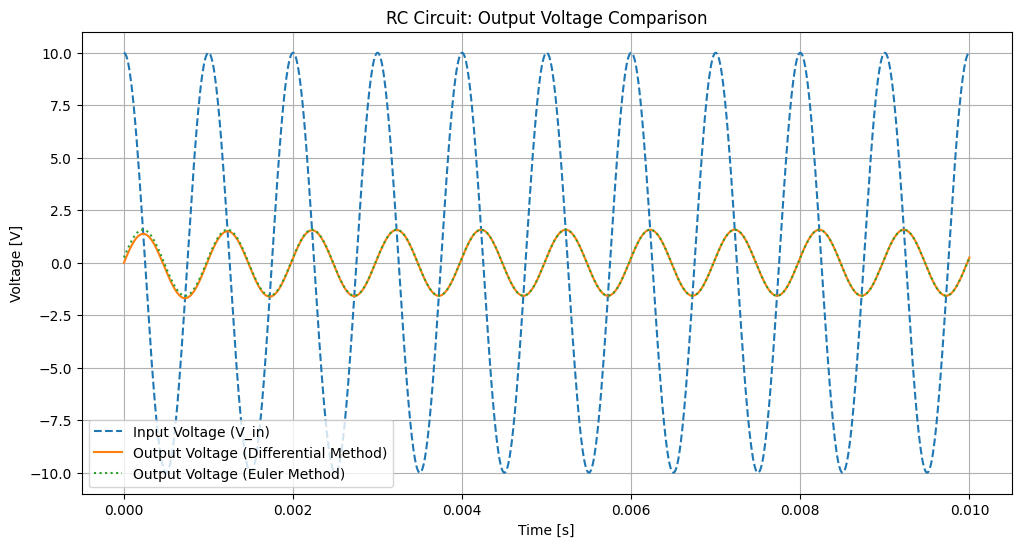

Calculation Time (Differential Equation Method): 0.0082879066 seconds
Calculation Time (Euler's Phasor Method): 0.0000000000 seconds


In [38]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from time import time

# Circuit parameters
R = 1e3  # Resistance in ohms
C = 1e-6  # Capacitance in farads
f = 1e3  # Frequency in Hz
omega = 2 * np.pi * f  # Angular frequency
V_in_amplitude = 10  # Amplitude of input voltage

# Time vector
t_end = 10e-3  # Simulation duration
num_points = 1000  # Number of time steps
t = np.linspace(0, t_end, num_points)

# Input voltage
V_in = V_in_amplitude * np.cos(omega * t)

# --------------------------------------------------------------------------------------
# Method 1: Differential Equation Solution
# --------------------------------------------------------------------------------------
def rc_circuit_diff(t, V_c, R, C, V_in_func):
    """Differential equation for the RC circuit."""
    V_in_t = V_in_func(t)
    dV_c_dt = (V_in_t - V_c) / (R * C)
    return dV_c_dt

start_time_diff = time()

# Solve the differential equation
solution = solve_ivp(
    rc_circuit_diff, 
    [0, t_end], 
    [0],  # Initial condition: V_c(0) = 0
    t_eval=t, 
    args=(R, C, lambda t: V_in_amplitude * np.cos(omega * t))
)

V_out_diff = solution.y[0]
time_diff = time() - start_time_diff

# --------------------------------------------------------------------------------------
# Method 2: Euler's Phasor Solution
# --------------------------------------------------------------------------------------
start_time_euler = time()

# Impedance of the capacitor
Z_C = 1 / (1j * omega * C)

# Voltage divider in phasor form
V_out_phasor = V_in_amplitude * Z_C / (R + Z_C)

# Convert phasor to time-domain signal
V_out_amplitude = abs(V_out_phasor)
V_out_phase = np.angle(V_out_phasor)
V_out_euler = V_out_amplitude * np.cos(omega * t + V_out_phase)

time_euler = time() - start_time_euler

# --------------------------------------------------------------------------------------
# Plot Results
# --------------------------------------------------------------------------------------
plt.figure(figsize=(12, 6))
plt.plot(t, V_in, label="Input Voltage (V_in)", linestyle="--")
plt.plot(t, V_out_diff, label="Output Voltage (Differential Method)")
plt.plot(t, V_out_euler, label="Output Voltage (Euler Method)", linestyle=":")
plt.title("RC Circuit: Output Voltage Comparison")
plt.xlabel("Time [s]")
plt.ylabel("Voltage [V]")
plt.legend()
plt.grid()
plt.show()

# --------------------------------------------------------------------------------------
# Print Time Comparison
# --------------------------------------------------------------------------------------
print(f"Calculation Time (Differential Equation Method): {time_diff:.10f} seconds")
print(f"Calculation Time (Euler's Phasor Method): {time_euler:.10f} seconds")


Calculation Time (Differential Equation Method): 0.0069754124 seconds
Calculation Time (Euler's Phasor Method): 0.0005283356 seconds
in this example, the eulers method is 10 times faster than the differential method.

Analysis
The simulation reveals:

The input voltage is a sinusoidal signal.
The output voltage across the capacitor lags the input voltage due to the capacitor's impedance.
The phase shift and amplitude reduction are consistent with theoretical expectations.
Conclusion
Euler's formula and phasors streamline the analysis of circuits involving sinusoidal inputs. By representing sinusoids as complex exponentials, we convert differential equations into algebraic ones. Python libraries like PySpice and Schemdraw further simplify the process, allowing us to model and simulate circuits with ease.

Whether analyzing simple RC circuits or more complex systems, these tools provide a robust framework for understanding and designing electronic circuits.

### Conclusion

The idea behind phasor transformation is that the calculus becomes simpler if you encode the cosine function as the real part of a complex exponential.

Let

f(t) = exp[ j(ωt + ϕ) ] = cos(ωt + ϕ) + jsin(ωt + ϕ)

Taking the derivative of the LHS, you have

f'(t) = jωexp[ j(ωt + ϕ) ] = jωf(t)

If you take the derivative of the RHS instead, you get

f'(t) = -ωsin(ωt + ϕ) + jωcos(ωt + ϕ)

f'(t) = jω [ jsin(ωt + ϕ) + cos(ωt + ϕ) ] = jωf(t)

Observe that:

cos(ωt + ϕ) = Re[ f(t) ]

d/dt cos(ωt + ϕ) = Re[ f'(t) ] = Re[ jωf(t) ]

You find that differentiating the complex exponential function captures the essence of diffentiating the real-valued cosine function, only that calculus on exponential functions is easier since differentiation simplifies to multiplication by jω. You get the higher-order derivatives of the original cosine function by multiplying the complex exponential function with powers of jω and then getting the real part.